In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde, multivariate_normal
from functools import partial

from src.hmc_class import HMCSampler, log_prob_mixture, grad_log_prob_mixture


# Define distributions & sampler

In [2]:
weights = np.array([0.1, 0.3, 1.3])
weights = weights / np.sum(weights)
means = np.array([[-2.0, 0.0], [2.0, 0.0], [0.0, 2.0]])
# covs = np.array([np.eye(d) * 0.5, np.eye(d) * 0.5, np.eye(d) * 0.5])
covs = np.array(
    [
        np.array([[0.7, 0.1], [0.1, 0.7]]),
        np.array([[0.5, -0.1], [-0.1, 0.5]]),
        np.array([[0.1, 0.0], [0.0, 0.1]]),
    ]
)

grad_weights = np.array([0.4, 0.3, 0.3])
grad_means = np.array([[-2.0, 0.0], [2.0, 0.0], [0.0, 2.0]])
grad_covs = np.array([np.eye(2) * 0.5, np.eye(2) * 0.5, np.eye(2) * 0.5])

In [3]:
log_prob_mixture = partial(log_prob_mixture, weights=weights, means=means, covariances=covs)
grad_log_prob_mixture = partial(grad_log_prob_mixture, weights=grad_weights, means=grad_means, covariances=grad_covs)

In [4]:
hmc = HMCSampler(log_prob_mixture, grad_log_prob_mixture)

# Leapfrog a couple of samples

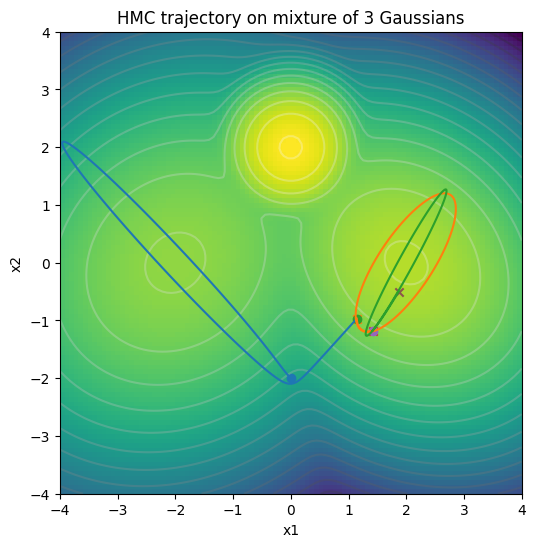

In [5]:
# Single long trajectory for visualisation
q0 = np.array([0.0, -2.0])
n_paths = 3
paths = []
for _ in range(n_paths):
    p0 = np.random.normal(size=2)
    # qT, pT, path = leapfrog(
    #     q0, p0, step_size=0.05, n_steps=100, grad_U=grad_U, return_path=True
    # )
    q0, pT, path = hmc.leapfrog(x=q0, p=p0, leapfrog_steps=100, step_size = 0.05)
    paths.append(path)

# Plot results
# Grid and contour plot
grid_lim = 4.0
xs = np.linspace(-grid_lim, grid_lim, 100)
ys = np.linspace(-grid_lim, grid_lim, 100)
X, Y = np.meshgrid(xs, ys)
Z = np.empty_like(X)
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = log_prob_mixture([X[i, j], Y[i, j]])

fig, ax = plt.subplots(figsize=(6, 6))
cs = ax.contour(X, Y, Z, levels=20, cmap="Grays_r", alpha=0.3)
im = ax.imshow(
    Z,
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    origin='lower',
    cmap='viridis',
    interpolation='nearest',
    aspect='auto'
)
# ax.clabel(cs, inline=True, fontsize=8)
for path in paths:
    ax.plot(path[:, 0], path[:, 1])
    ax.scatter(path[0, 0], path[0, 1], marker="o")
    ax.scatter(path[-1, 0], path[-1, 1], marker="x")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("HMC trajectory on mixture of 3 Gaussians")
ax.set_aspect("equal")
plt.show()

# Sample points

In [6]:
# np.random.seed(np.random.randint(0, 99999))
np.random.seed(0)

dim = 2
n_samples = 100
leapfrog_steps = 20
step_size = 0.1
initial_q = np.array([0.0, 0.0])

start = perf_counter()
samples_hmc, acceptance_rate_hmc = hmc.sample(
    n_samples,
    leapfrog_steps,
    initial_q,
    step_size,
    dim,
)
time_hmc = perf_counter() - start

print(f"HMC sampling took {time_hmc:.3f} seconds.")
print(f"HMC acceptance rate: {acceptance_rate_hmc:.3f}")

HMC sampling took 0.093 seconds.
HMC acceptance rate: 0.890


## Plot samples

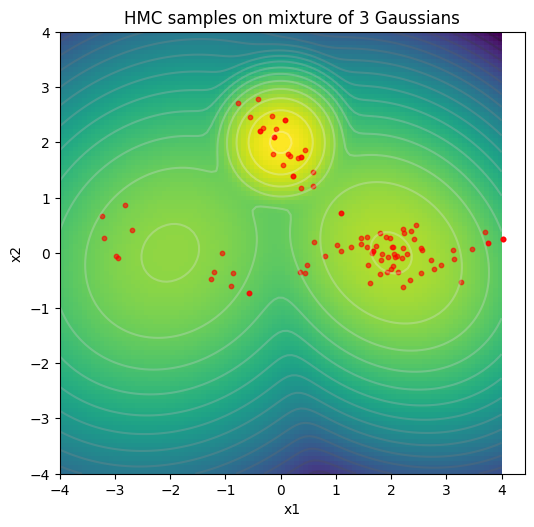

In [7]:
# Plot samples on top of contour plot
fig, ax = plt.subplots(figsize=(6, 6))
cs = ax.contour(X, Y, Z, levels=20, cmap="Grays_r", alpha=0.3)
im = ax.imshow(
    Z,
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    origin='lower',
    cmap='viridis',
    interpolation='nearest',
    aspect='auto'
)
ax.scatter(samples_hmc[:, 0], samples_hmc[:, 1], color="red", s=10, alpha=0.6)
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("HMC samples on mixture of 3 Gaussians")
ax.set_aspect("equal")
plt.show()

# Metropolis for comparison

In [8]:
def metropolis_sample(log_prob, n_samples, proposal_scale, dim, initial_q):
    """
    Random-walk Metropolis sampler for baseline comparison.

    log_prob: function returning unnormalised log density
    n_samples: number of samples
    proposal_scale: standard deviation of Gaussian proposal
    dim: dimension of the state space
    initial_q: initial position, shape (dim,)

    Returns:
        samples of shape (n_samples, dim)
    """
    samples = np.zeros((n_samples, dim))
    accepted = 0
    q = np.asarray(initial_q, dtype=float).copy()

    for i in range(n_samples):
        # Gaussian random-walk proposal
        q_prop = q + proposal_scale * np.random.normal(size=dim)

        current_logp = log_prob(q)
        proposed_logp = log_prob(q_prop)

        log_accept_ratio = proposed_logp - current_logp

        if np.log(np.random.rand()) < log_accept_ratio:
            q = q_prop
            accepted += 1

        samples[i] = q

    return samples, accepted / n_samples

In [9]:
# Plot the full path of Metropolis samples
q0 = np.array([0.0, -2.0])
start = perf_counter()
samples_metropolis, acc_rate = metropolis_sample(
    log_prob=log_prob_mixture,
    n_samples=n_samples,
    proposal_scale=0.5,
    dim=2,
    initial_q=q0,
)
time_metropolis = perf_counter() - start

print(f"Metropolis sampling took {time_metropolis:.3f} seconds.")
print(f"Metropolis acceptance rate: {acc_rate:.3f}")

Metropolis sampling took 0.007 seconds.
Metropolis acceptance rate: 0.620


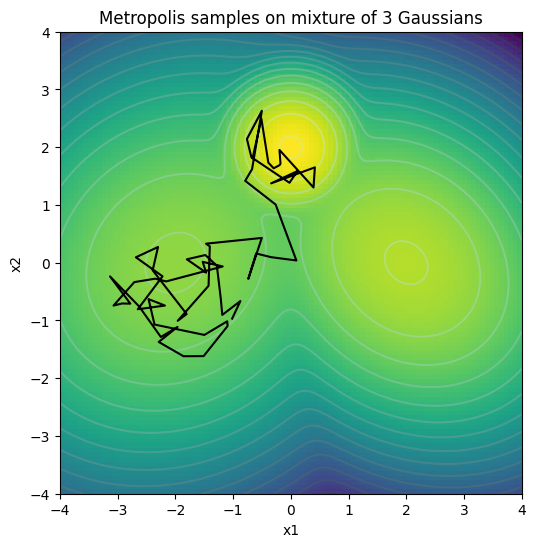

In [10]:
# Contour plot plus Metropolis path
fig, ax = plt.subplots(figsize=(6, 6))
cs = ax.contour(X, Y, Z, levels=20)
cs = ax.contour(X, Y, Z, levels=20, cmap="Grays_r", alpha=0.3)
im = ax.imshow(
    Z,
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    origin='lower',
    cmap='viridis',
    interpolation='nearest',
    aspect='auto'
)
ax.plot(samples_metropolis[:, 0], samples_metropolis[:, 1], color="k")
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_title("Metropolis samples on mixture of 3 Gaussians")
ax.set_aspect("equal")
plt.show()

# KL Divergence comparison

In [11]:
def log_true_density(x):
    vals = [
        w * multivariate_normal.pdf(x, mean=m, cov=c)
        for w, m, c in zip(weights, means, covs)
    ]
    return np.log(np.sum(vals))


def kl_samples_vs_target(samples):
    samples = np.asarray(samples)

    kde = gaussian_kde(samples.T)
    log_p_hat = np.log(kde(samples.T))
    log_p_true = np.array([log_true_density(x) for x in samples])

    return np.mean(log_p_hat - log_p_true)

In [12]:
# KL divergence for Hamiltonian Monte Carlo samples
kl_hmc = kl_samples_vs_target(samples_hmc)
print("KL divergence (samples vs target):", kl_hmc)

KL divergence (samples vs target): 0.8477182935216331


In [13]:
# KL divergence for Metropolis samples
kl_metropolis = kl_samples_vs_target(samples_metropolis)
print("KL divergence (samples vs target):", kl_metropolis)

KL divergence (samples vs target): 1.4412396378805588
